<span style="font-size: 14pt">MIPT, Applied ML, Autumn 2018</span>

<span style="font-size: 16pt"> HW #4: Approximate RL homework

<span style="color:red; font-size: 14pt;"> Дедлайн 19.11.2018 23:59 </span>

<span style="color:blue; font-size: 12pt">Valentin Malykh </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">val@maly.hk</span>

**Оформление дз**: 
- Выполненное задание требуется отправлять через <a href='https://goo.gl/forms/XPSIbwp7wPxB4SsI3'>форму </a>

- Выполненное дз прикрепляйте в формате файла ``<фамилия>_<группа>_task<номер>.ipynb``, например: ``ivanov_594_task4.ipynb`` 

**Вопросы**:
- Вопросы присылайте в канал в телеграмме ``[Fall 2018]ML Seminars``

--------
- **PS1**: Будьте внимательны при заполнении формы, когда отправляете ДЗ 

<h1 align="center">Практическое задание (100%)</h1>
Описание находится по ссылке: https://gist.github.com/madrugado/1262c3077bf7d8ac8166e4350f0f67e2

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import FloatTensor, LongTensor

import gym
np.random.seed(42)

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
env = gym.make('LunarLander-v2')
env.reset()

array([ 0.00775785,  1.412831  ,  0.7857589 ,  0.08490189, -0.0089825 ,
       -0.17798623,  0.        ,  0.        ], dtype=float32)

In [3]:
class Lander(nn.Module):
    def __init__(self, env, num_env_actions, num_env_variables):
        super().__init__()
        self.env = env
        self.num_env_actions = num_env_actions
        self.num_env_variables = num_env_variables
        self.memoryX = np.zeros(1)
        self.memoryY = np.zeros(1)
        self.criterion = nn.MSELoss()
        self.optimizer = None
        
        self._dence_1 =nn.Sequential( nn.Linear(num_env_actions + num_env_variables, 512), nn.ReLU() )
        self._dence_2 =nn.Sequential( nn.Linear(512, 256), nn.ReLU() )
        self._dence_3 =nn.Sequential( nn.Linear(256, 256), nn.ReLU() )
        self._out = nn.Linear(256, 1)

    def forward(self, inputs):
        x = self._dence_1(inputs)
        x = self._dence_2(x)
        x = self._dence_3(x)
        x = self._out(x)
        return x
    
    def one_hot(self, action):
        result = np.zeros(self.num_env_actions)
        result[action] = 1
        return result

    def predict_total_reward(self, state, action):
        state_action = np.concatenate((state, self.one_hot(action)), axis = 0)
        total_reward = self.forward(FloatTensor(state_action.reshape(1, -1))).flatten()
        return total_reward

    def random_action(self):
        return self.env.action_space.sample()

    def normal_action(self, state):
        possible_action = np.array([self.predict_total_reward(state, i) for i in range(self.num_env_actions)])
        return np.argmax(possible_action)

    def get_action(self, state, explore = 0.5, observe = False):
        if observe:
            return self.random_action()
        prob = np.random.rand(1)
        if prob > explore:
            return self.random_action()
        return self.normal_action(state)

    def play_game(self, observe = False, explore = 0.5, gamma = 0.99, render = False):
        gameX = np.zeros(shape=(1,num_env_variables+num_env_actions))
        gameY = np.zeros(shape=(1,1))
        state = self.env.reset()
        done = False
        step = 0
        total_reward = 0
        while not done:
            action = self.get_action(state, explore, observe)
            if render:
                env.render()
            state_action = np.concatenate((state, self.one_hot(action)), axis = 0)
            state, reward, done, info = self.env.step(action)
            total_reward += reward
            if step == 0:
                gameX[0] = state_action
                gameY[0] = np.array([reward])
            else:
                gameX = np.vstack((gameX, state_action))
                gameY = np.vstack((gameY, np.array([reward])))
            step += 1
        for i in range(0,gameY.shape[0]):
            if i > 0:
                gameY[(gameY.shape[0]-1)-i][0] = gameY[(gameY.shape[0]-1)-i][0] + gamma * gameY[(gameY.shape[0]-1) - i + 1][0]
        return np.array(gameX), np.array(gameY), total_reward
    
    def update_memory(self, gameX, gameY):
        if self.memoryX.shape[0] == 1:
            self.memoryX = gameX
            self.memoryY = gameY
        else:
            self.memoryX = np.concatenate((self.memoryX, gameX), axis=0)
            self.memoryY = np.concatenate((self.memoryY, gameY), axis=0)
        max_memory = 10000
        if len(self.memoryX > max_memory):
            self.memoryX = self.memoryX[-max_memory:]
            self.memoryY = self.memoryY[-max_memory:]
            
    def train(self):
        if self.optimizer is None:
            self.optimizer = optim.Adam(self.parameters(), lr=1e-5)
        with torch.autograd.set_grad_enabled(True):
            for i in range(12):
                batch_ids = np.random.choice(len(self.memoryX), 512)
                batch = self.memoryX[batch_ids]
                target = self.memoryY[batch_ids]
                prediction = self.forward(FloatTensor(batch))
                loss = self.criterion(prediction, FloatTensor(target))
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            
    
    def train_model(self, steps, observe=False, explore=0.5, gamma=0.99, render=False):
        with tqdm(total=steps) as pbar:
            for _ in range(steps):
                gameX, gameY, _ = self.play_game(observe, explore, gamma, render)
                self.update_memory(gameX, gameY)
                if not observe:
                    self.train()
                pbar.update()

In [4]:
num_env_variables = 8
num_env_actions = 4

In [5]:
model = Lander(env, num_env_actions, num_env_variables)
#загрузка сохраненной модели
model.load_state_dict(torch.load('model'))


Mean reward for 1000 games : 233.16637155736754
Successes count: 934


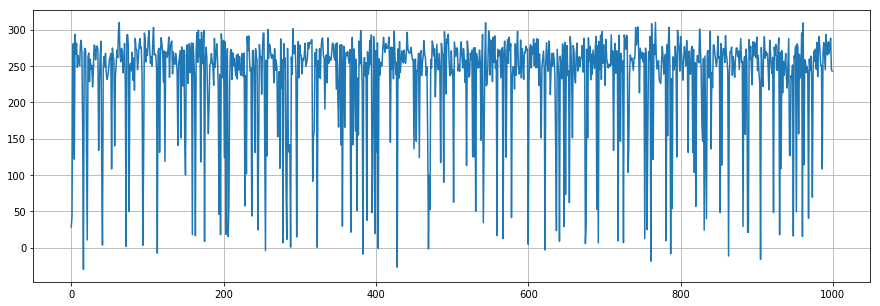

In [16]:
rewards = []
num_iters = 1000
with tqdm(total=num_iters) as pbar:
    for i in range(num_iters):
        game_x, game_y, total = model.play_game(explore = 1, render = False)
        rewards.append(total)
        pbar.update()
plt.figure(figsize=(15,5))
plt.plot(rewards)
plt.grid()
print('Mean reward for ' + str(num_iters) + ' games : ' + str(np.mean(rewards)))
print('Successes count: ' + str(np.sum([1 if item > 50 else 0 for item in rewards])))

In [14]:
for i in range(10):
    game_x, game_y, total = model.play_game(explore = 1, render = False)
    print(total)

230.13389733826688
283.4274020634427
261.66443783527995
275.1465900374178
240.61530247085716
258.72797698138436
296.5305401746114
269.39862887509486
279.5289774564681
279.66850459157445


In [8]:
# код для тренировки модели
model.train_model(5000, observe=True)
model.train_model(4000, explore = 0.2, render=False, gamma=0.99)
model.train_model(4000, explore = 0.9, render=False, gamma=0.99)

In [ ]:
torch.save(model.state_dict(), 'model')